In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [5]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

In [6]:
%run setup_notebooks.py

In [7]:
from src import setup

In [8]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Load

In [7]:
from datasets import split_data, PatientDataset
from create_data import read_tsvi

In [10]:
config = {
    'dataset.name': 'CoordToCnc_perimeter',
    'dataset.num_node_features': 1,
    'cv.seed': 0,
    'cv.k_fold': 5,
    'dataset.in_memory': True
}

test_set, split_list = split_data(path=setup.get_dataset_path(config['dataset.name']),
                                  num_node_features=config['dataset.num_node_features'],
                                  seed=config['cv.seed'],
                                  cv=True,
                                  k_cross=config['cv.k_fold'],
                                  # Args for PatientDataset
                                  in_memory=config['dataset.in_memory'])

# Load tsvi
path_data_in, _ = setup.get_data_paths()
path_labels = path_data_in.joinpath('CFD/labels/WSSdescriptors_AvgValues.xlsx')
data_tsvi = read_tsvi(path_labels)

2022-06-01 16:39:35,213 [setup] [INFO] get_data_path(): using user-defined data path
2022-06-01 16:39:35,214 [setup] [INFO] get_data_path(): using user-defined data path
2022-06-01 16:39:39,518 [datasets] [INFO] split_data (test_set, split_list) = (PatientDataset(19, type=test, in_memory=True), [(PatientDataset(133, type=train, in_memory=True), PatientDataset(36, type=val, in_memory=True)), (PatientDataset(135, type=train, in_memory=True), PatientDataset(34, type=val, in_memory=True)), (PatientDataset(135, type=train, in_memory=True), PatientDataset(34, type=val, in_memory=True)), (PatientDataset(138, type=train, in_memory=True), PatientDataset(31, type=val, in_memory=True)), (PatientDataset(135, type=train, in_memory=True), PatientDataset(34, type=val, in_memory=True))])
2022-06-01 16:39:39,518 [datasets] [INFO] sanity checking data splits
2022-06-01 16:39:39,540 [setup] [INFO] get_data_path(): using user-defined data path
2022-06-01 16:39:39,541 [create_data] [INFO] parsing tsvi ...


## Quadratic forms

In [11]:
path = setup.get_dataset_path('graph_features')
data_quadratic = torch.load(path.joinpath('perimeters.pt'))
print(data_quadratic.keys())
data_quadratic = data_quadratic['features']

2022-06-01 16:39:42,515 [setup] [INFO] get_data_path(): using user-defined data path


dict_keys(['input_dset', 'taus', 'features'])


In [12]:
data_quadratic_simple = {
    k: v[0] for k, v in data_quadratic.items()
}

# Models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
from baseline import Dataset, Model

## Toy Example

In [15]:
dset_tsvi = Dataset(include_tsvi=data_tsvi)

In [16]:
logreg_tsvi = Model(LogisticRegression(class_weight='balanced'), dset_tsvi)
logreg_tsvi_summary = logreg_tsvi.pipeline(split_list, test_set)
logreg_tsvi_summary.T

,train.1.auc,val.1.auc,test.1.auc,train.accuracy,train.0.precision,train.0.recall,train.0.f1-score,train.1.precision,train.1.recall,train.1.f1-score,...,val.1.precision,val.1.recall,val.1.f1-score,test.accuracy,test.0.precision,test.0.recall,test.0.f1-score,test.1.precision,test.1.recall,test.1.f1-score
mean,0.790503,0.751577,0.547727,0.744259,0.773754,0.786063,0.779234,0.704981,0.687417,0.695062,...,0.651707,0.654286,0.648179,0.536842,0.593077,0.636364,0.612836,0.446032,0.400000,0.419832
std,0.025833,0.117007,0.039691,0.030155,0.036106,0.033919,0.024422,0.034655,0.066180,0.043213,...,0.100024,0.165835,0.122463,0.023538,0.014408,0.064282,0.034146,0.030942,0.055902,0.030954


In [17]:
logreg_tsvi.describe_model()

{'model_name': 'LogisticRegression',
 'model_class_weight': 'balanced',
 'data_tsvi': False,
 'data_node_feat': False,
 'data_graph_feat': True,
 'data_feature_names': ['artery_0', 'artery_1', 'artery_2', 'tsvi']}

## Automate

In [18]:
quad_feat_names = ['x^TLx']
quad_feat_names_full = quad_feat_names + [f'x{i+1}^TLx{i+1}' for i in range(next(iter(data_quadratic.values())).shape[0]-1)]

datasets = [
    # Only artery type
    Dataset(),
    # Artery type + Tsvi
    Dataset(include_tsvi=data_tsvi),
    # Quadratic form with Laplacian only
    Dataset(additional_graph_features=data_quadratic_simple, additional_graph_feature_names=quad_feat_names),
    # Quadratic form with diffusion
    Dataset(additional_graph_features=data_quadratic, additional_graph_feature_names=quad_feat_names_full),
    # Quadratic forms with tsvi
    Dataset(include_tsvi=data_tsvi, additional_graph_features=data_quadratic_simple, additional_graph_feature_names=quad_feat_names),
    Dataset(include_tsvi=data_tsvi, additional_graph_features=data_quadratic, additional_graph_feature_names=quad_feat_names_full),
]

In [19]:
# List of tuples:
# (model, params)   - model is an instanciation of a sklearn model 
#                   - params is a dictionnary for grid search
C_grid = np.logspace(-3, 3, 20)
sklearn_models = [
    (
        LogisticRegression(class_weight='balanced'),
        {'C': C_grid}
    ),
    (
        SVC(class_weight='balanced', probability=True),
        {'C': C_grid, 'kernel': ('linear', 'rbf', 'poly')}
    ),
    (
        DecisionTreeClassifier(class_weight='balanced'),
        {'min_samples_leaf': (2, 5, 10,), 'max_depth': (2, 3, 4, 5, 6, 10)}
    ),
    (
        RandomForestClassifier(class_weight='balanced'),
        {'max_depth': (2, 3, 4, 5, 6), 'min_samples_leaf': (2, 5, 10)}
    )
]

### Hyperparameter tuning

In [37]:
results = []
kfold = 5
for i, dset in enumerate(datasets):
    for j, (sklearn_model, grid) in enumerate(sklearn_models):
        print('.', end='')
        model = Model(sklearn_model, dset)
        res = model.grid_search(split_list, grid, kfold=kfold)
        
        results.append({
            'id_dataset': i,
            'id_model': j,
            'config': model.describe_model(),
            'tuning': res
        })

........................

In [38]:
def get_best_model(tuning_results, dataset_id: int, verbose: bool = True):
    samples = [e for e in tuning_results if e['id_dataset'] == dataset_id]
    df_res = []
    for e in samples:
        sub = e['tuning'].copy()
        sub['id_model'] = e['id_model']
        sub['model_name'] = e['config']['model_name']
        df_res.append(sub)
    
    df_res = pd.concat(df_res, ignore_index=True)
    df_res['score'] = df_res.mean_test_score - df_res.std_test_score
    df_res.sort_values('score', ascending=False, inplace=True, )
    
    if verbose:
        nbest = 5
        df_show = df_res.iloc[:nbest][['mean_test_score', 'std_test_score', 'model_name']]
        print(f'top {nbest} results:\n{df_show}')
    
    winner = df_res.iloc[0]
    params = {
        '_'.join(col.split('_')[1:]): winner[col]
        for col in df_res.columns
        if 'param_' in col and not pd.isna(winner[col])
    }
    
    return winner.id_model, params

In [39]:
get_best_model(results, 1)

top 5 results:
     mean_test_score  std_test_score              model_name
82          0.696794        0.034006  DecisionTreeClassifier
80          0.696794        0.034006  DecisionTreeClassifier
81          0.696794        0.034006  DecisionTreeClassifier
112         0.697783        0.040943  RandomForestClassifier
103         0.704842        0.053108  RandomForestClassifier


(2, {'max_depth': 2, 'min_samples_leaf': 10})

In [40]:
tuning_winners = [
    (id_dataset, *get_best_model(results, id_dataset))
    for id_dataset in range(len((datasets)))
]

top 5 results:
     mean_test_score  std_test_score              model_name
98          0.507347        0.096241  RandomForestClassifier
107         0.507347        0.096241  RandomForestClassifier
99          0.507347        0.096241  RandomForestClassifier
101         0.507347        0.096241  RandomForestClassifier
105         0.507347        0.096241  RandomForestClassifier
top 5 results:
     mean_test_score  std_test_score              model_name
82          0.696794        0.034006  DecisionTreeClassifier
80          0.696794        0.034006  DecisionTreeClassifier
81          0.696794        0.034006  DecisionTreeClassifier
112         0.697783        0.040943  RandomForestClassifier
103         0.704842        0.053108  RandomForestClassifier
top 5 results:
     mean_test_score  std_test_score              model_name
112         0.603806        0.072971  RandomForestClassifier
103         0.603806        0.072971  RandomForestClassifier
97          0.541831        0.030134  De

In [41]:
tuning_winners

[(0, 3, {'max_depth': 2, 'min_samples_leaf': 2}),
 (1, 2, {'max_depth': 2, 'min_samples_leaf': 10}),
 (2, 3, {'max_depth': 6, 'min_samples_leaf': 10}),
 (3, 2, {'max_depth': 2, 'min_samples_leaf': 2}),
 (4, 2, {'max_depth': 2, 'min_samples_leaf': 5}),
 (5, 2, {'max_depth': 2, 'min_samples_leaf': 2})]

### Refit and test

In [42]:
res = []
for id_dataset, id_model, params in tuning_winners:
    clf, _ = sklearn_models[id_model]
    clf.set_params(**params)
    print(clf.__class__.__name__)
    model = Model(clf, datasets[id_dataset])
    summary = model.pipeline(split_list, test_set)
    buffer = model.describe_model()
    buffer['summary'] = summary
    res.append(buffer)

RandomForestClassifier
DecisionTreeClassifier
RandomForestClassifier
DecisionTreeClassifier
DecisionTreeClassifier
DecisionTreeClassifier


In [43]:
torch.save(res, 'data/baseline_results.pt')

---

In [9]:
res = torch.load('data/baseline_results.pt')

In [10]:
ms = ['val.1.f1-score', 'val.0.recall', 'val.1.auc', 'test.1.f1-score', 'test.0.recall', 'test.1.auc']
df = []
for dic in res:
    df.append({
        'model': dic['model_name'],
        'features': dic['data_feature_names'],
    })
    for m in ms:
        df[-1].update({
            m + '.mean': dic['summary'].loc[m, 'mean'] for m in ms
        })
        df[-1].update({
            m + '.std': dic['summary'].loc[m, 'std'] for m in ms
        })
        
df_plot = pd.DataFrame(df)

In [11]:
df_plot

,model,features,val.1.f1-score.mean,val.0.recall.mean,val.1.auc.mean,test.1.f1-score.mean,test.0.recall.mean,test.1.auc.mean,val.1.f1-score.std,val.0.recall.std,val.1.auc.std,test.1.f1-score.std,test.0.recall.std,test.1.auc.std
0,RandomForestClassifier,"[artery_0, artery_1, artery_2]",0.500585,0.644455,0.529129,0.309091,0.418182,0.361364,0.127101,0.229141,0.095455,0.132131,0.081312,0.049793
1,DecisionTreeClassifier,"[artery_0, artery_1, artery_2, tsvi]",0.696175,0.536844,0.747386,0.613233,0.490909,0.531818,0.037544,0.172123,0.062229,0.027076,0.081312,0.052936
2,RandomForestClassifier,"[artery_0, artery_1, artery_2, x^TLx]",0.562697,0.561302,0.596413,0.619748,0.618182,0.697727,0.116223,0.129984,0.083456,0.104156,0.235312,0.078153
3,DecisionTreeClassifier,"[artery_0, artery_1, artery_2, x^TLx, x1^TLx1,...",0.566891,0.513953,0.616992,0.661422,0.490909,0.761364,0.130029,0.091326,0.091589,0.107302,0.218938,0.026650
4,DecisionTreeClassifier,"[artery_0, artery_1, artery_2, tsvi, x^TLx]",0.696175,0.536844,0.750995,0.613233,0.490909,0.532955,0.037544,0.172123,0.053120,0.027076,0.081312,0.064583
5,DecisionTreeClassifier,"[artery_0, artery_1, artery_2, tsvi, x^TLx, x1...",0.679508,0.497320,0.744207,0.652982,0.490909,0.625000,0.023574,0.140255,0.015393,0.077445,0.081312,0.076230


In [12]:
def name_features(features):
    concat = ' '.join(features)
    names = []
    if 'artery' in concat:
        names.append('Artery type')
    if 'tsvi' in concat:
        names.append('Tsvi')
    if 'x^TLx' in concat:
        names.append('Quadratic form')
    if 'x1^TLx1' in concat:
        names.append('Quadratic form with exponential')
    
    return '\n+'.join(names)

In [13]:
list(map(name_features, df_plot.features.values))

['Artery type',
 'Artery type\n+Tsvi',
 'Artery type\n+Quadratic form',
 'Artery type\n+Quadratic form\n+Quadratic form with exponential',
 'Artery type\n+Tsvi\n+Quadratic form',
 'Artery type\n+Tsvi\n+Quadratic form\n+Quadratic form with exponential']

In [14]:
df_plot.features

0                       [artery_0, artery_1, artery_2]
1                 [artery_0, artery_1, artery_2, tsvi]
2                [artery_0, artery_1, artery_2, x^TLx]
3    [artery_0, artery_1, artery_2, x^TLx, x1^TLx1,...
4          [artery_0, artery_1, artery_2, tsvi, x^TLx]
5    [artery_0, artery_1, artery_2, tsvi, x^TLx, x1...
Name: features, dtype: object

In [15]:
list(map(name_features, df_plot.features))

['Artery type',
 'Artery type\n+Tsvi',
 'Artery type\n+Quadratic form',
 'Artery type\n+Quadratic form\n+Quadratic form with exponential',
 'Artery type\n+Tsvi\n+Quadratic form',
 'Artery type\n+Tsvi\n+Quadratic form\n+Quadratic form with exponential']

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  del sys.path[0]
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-pac

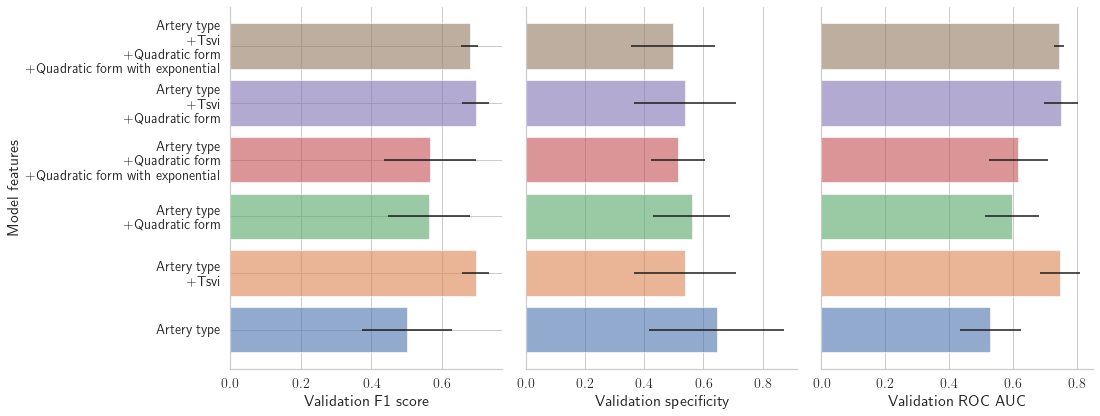

In [21]:
ms = ['val.1.f1-score', 'val.0.recall', 'val.1.auc']
df_tmp = df_plot.copy()
df_tmp.index = df_tmp.features.apply(name_features)

_, ax = plt.subplots(1, len(ms), figsize=(len(ms) * 5 + 0.5, 6))
colors = sns.color_palette('deep', n_colors=df_tmp.shape[0])
for a, m in zip(ax, ms):
    l = a.barh(y=df_tmp.index, width=df_tmp[(m+'.mean')], xerr=df_tmp[(m+'.std')], alpha=0.6, color=colors)
    a.set_xlabel(m)
    a.set_yticklabels(list(map(name_features, df_tmp.features)))
    
for a in ax[1:]:
    a.set_yticks([])
ax[0].set_xlabel('Validation F1 score')
ax[1].set_xlabel('Validation specificity')
ax[2].set_xlabel('Validation ROC AUC')
ax[0].set_ylabel('Model features')
#plt.suptitle('Baseline models results on validation set')
#plt.suptitle(r'Baseline model results, quadratic form refers to $\mathbf x^\top L \mathbf x$, with exponential refers to '
#             r'$(\mathbf x^\top e^{-\tau L}) L (e^{-\tau L} \mathbf x)$ for $\tau = 1,3,5,9$')
plt.tight_layout()
process_figure('figs/baseline_validation.pdf')

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  # Remove the CWD from sys.path while we load stuff.


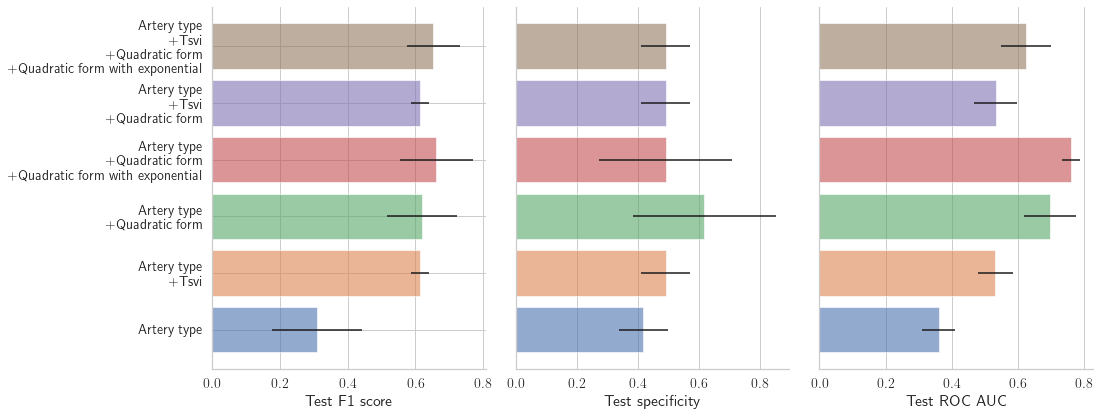

In [22]:
ms = ['test.1.f1-score', 'test.0.recall', 'test.1.auc']

_, ax = plt.subplots(1, len(ms), figsize=(len(ms) * 5 + 0.5, 6))
colors = sns.color_palette('deep', n_colors=df_tmp.shape[0])
for a, m in zip(ax, ms):
    l = a.barh(y=df_tmp.index, width=df_tmp[(m+'.mean')], xerr=df_tmp[(m+'.std')], alpha=0.6, color=colors)
    a.set_xlabel(m)
    
for a in ax[1:]:
    a.set_yticks([])
ax[0].set_xlabel('Test F1 score')
ax[1].set_xlabel('Test specificity')
ax[2].set_xlabel('Test ROC AUC')
plt.tight_layout()
process_figure('figs/baseline_test.pdf')

## Alternative Test splits

We try an alternative splitting procedure: just do 100 randoom train/test splits and use models that were selected above.

In [55]:
config = {
    'dataset.name': 'CoordToCnc_perimeter',
    'dataset.num_node_features': 1,
    'cv.seed': 0,
    'dataset.in_memory': True
}

test_set, split_list = split_data(path=setup.get_dataset_path(config['dataset.name']),
                                  num_node_features=config['dataset.num_node_features'],
                                  seed=config['cv.seed'],
                                  cv=False,
                                  
                                  # Args for PatientDataset
                                  in_memory=config['dataset.in_memory'])

2022-06-01 17:22:55,932 [setup] [INFO] get_data_path(): using user-defined data path
2022-06-01 17:22:55,933 [setup] [INFO] get_data_path(): using user-defined data path
2022-06-01 17:22:56,077 [datasets] [INFO] split_data (test_set, split_list) = (PatientDataset(19, type=test, in_memory=True), [(PatientDataset(117, type=train, in_memory=True), PatientDataset(52, type=val, in_memory=True))])
2022-06-01 17:22:56,077 [datasets] [INFO] sanity checking data splits


In [56]:
test_set, split_list

(PatientDataset(19, type=test, in_memory=True),
 [(PatientDataset(117, type=train, in_memory=True),
   PatientDataset(52, type=val, in_memory=True))])

In [57]:
dataset = test_set + split_list[0][0] + split_list[0][1]
dataset

PatientDataset(188, type=None, in_memory=True)

In [58]:
test_ratio = 0.2
n = 100

split_list = [
    dataset.split(test_ratio) for _ in range(n)
]

In [59]:
res = []
for id_dataset, id_model, params in tuning_winners:
    clf, _ = sklearn_models[id_model]
    clf.set_params(**params)
    print(clf.__class__.__name__)
    model = Model(clf, datasets[id_dataset])
    summary = model.pipeline(split_list, test_set)
    buffer = model.describe_model()
    buffer['summary'] = summary
    res.append(buffer)

RandomForestClassifier
DecisionTreeClassifier
RandomForestClassifier
DecisionTreeClassifier
DecisionTreeClassifier
DecisionTreeClassifier


In [60]:
ms = ['val.1.f1-score', 'val.0.recall', 'val.1.auc', 'test.1.f1-score', 'test.0.recall', 'test.1.auc']
df = []
for dic in res:
    df.append({
        'model': dic['model_name'],
        'features': dic['data_feature_names'],
    })
    for m in ms:
        df[-1].update({
            m + '.mean': dic['summary'].loc[m, 'mean'] for m in ms
        })
        df[-1].update({
            m + '.std': dic['summary'].loc[m, 'std'] for m in ms
        })
        
df_plot = pd.DataFrame(df)

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  del sys.path[0]
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-pac

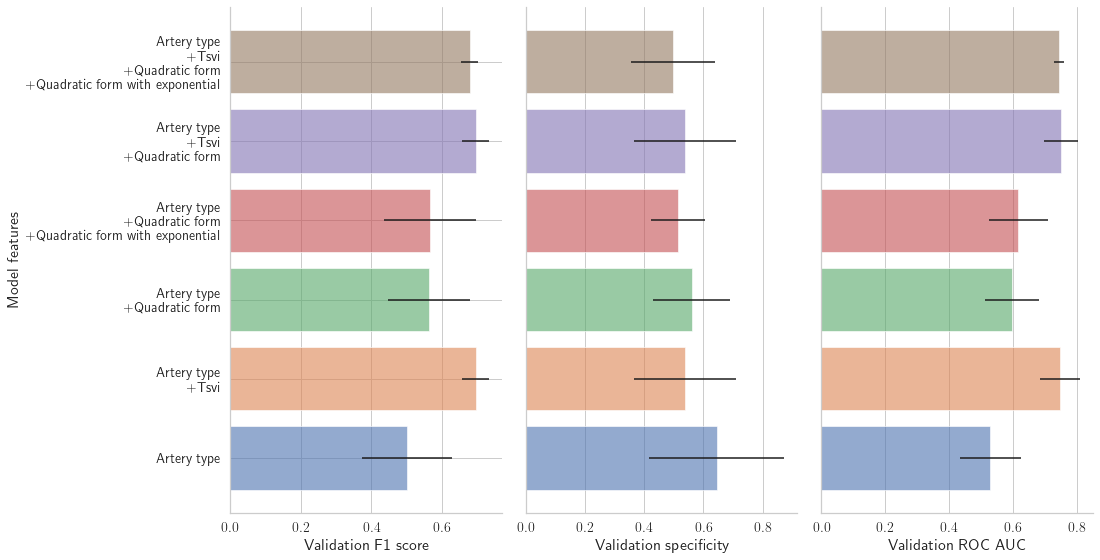

In [23]:
ms = ['val.1.f1-score', 'val.0.recall', 'val.1.auc']
df_tmp = df_plot.copy()
df_tmp.index = df_tmp.features.apply(name_features)

_, ax = plt.subplots(1, len(ms), figsize=(len(ms) * 5 + 0.5, 8))
colors = sns.color_palette('deep', n_colors=df_tmp.shape[0])
for a, m in zip(ax, ms):
    l = a.barh(y=df_tmp.index, width=df_tmp[(m+'.mean')], xerr=df_tmp[(m+'.std')], alpha=0.6, color=colors)
    a.set_xlabel(m)
    a.set_yticklabels(list(map(name_features, df_tmp.features)))
    
for a in ax[1:]:
    a.set_yticks([])
ax[0].set_xlabel('Validation F1 score')
ax[1].set_xlabel('Validation specificity')
ax[2].set_xlabel('Validation ROC AUC')
ax[0].set_ylabel('Model features')
#plt.suptitle(r'Baseline model results, alternative split procedure')
plt.tight_layout()
process_figure('figs/baseline_validation_alternative.pdf')

In [26]:
df_tmp.to_csv('data/baseline_mc.csv')